In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
!pip install langchain sentence-transformers faiss-cpu pypdf transformers torch langchain-community  #instalujemy potrzebne biblioteki

In [72]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
from langchain.chains import RetrievalQA
import os
from sentence_transformers import SentenceTransformer
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory

# MOŻESZ IMPORTOWAĆ INNE BIBLIOTEKI, ALE PAMIĘTAJ O ICH INSTALACJI W WIERSZU POWYŻEJ !!!

# Asystent AI - PDF RAG
Po dwóch udanych misjach – rozwikłaniu tajemnicy przeżycia na Titanicu i odczytaniu ręcznych notatek o pokojach – myślałeś, że zasłużysz na odpoczynek. Jednak telefon od tajemniczego zleceniodawcy rozbrzmiał ponownie, tym razem z jeszcze pilniejszą sprawą.

"Wasze poprzednie modele były kluczowe," – rozpoczął głos w słuchawce – "ale to dopiero wstęp do prawdziwego wyzwania. Nasi agenci przechwycili poufny szpont dokumentów. To nie są zwykłe papiery; to zestaw od 3 do 5 artykułów naukowych w formacie PDF, które zawierają fragmenty przełomowych badań. Informacje są niekompletne, celowo pomieszane i zaszyfrowane."

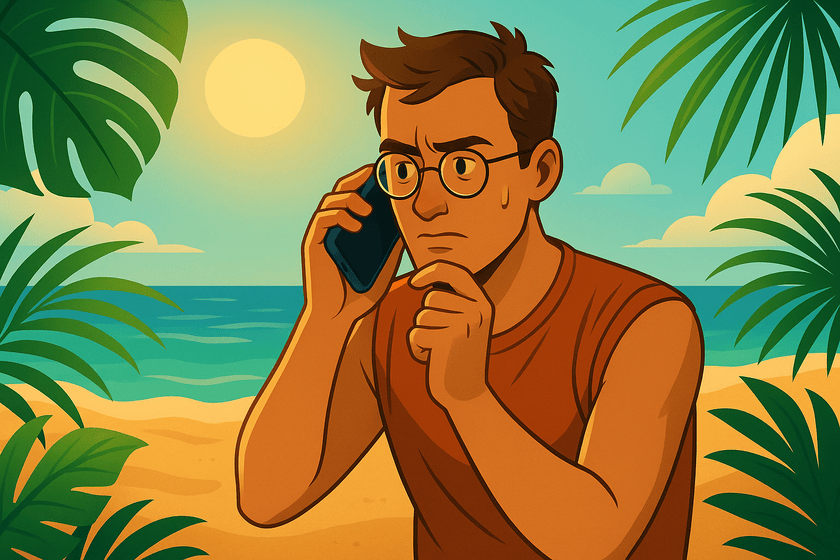

(*AI-generated image*)

### Zadanie
Twoim celem będzie stworzenie asystenta RAG - Retrival Augmented Generation na podstawie kilku plików PDF z artykułami naukowymi na wybrany przez siebie temat (3-5 artykułów).
### Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:
- Czy model poprawnie odpowiada na pytania ?
- Jakie są etapy przetwarzania dokumentu tekstowego ?
- Jaki wynik jest "dobry" ?
- Co robi mój asystent AI ? Jak on działa ? Jak tworzona jest odpowiedź ?
- Czy model poprawnie wybiera fragment dokumentu ? Czy poprawnie korzysta z bazy ?
- Jaką rolę w naszym systemie pełni baza wektorowa ?

### Wymagania
- Przygotuj artykuły naukowe i umieść je w folderze na dysku
- Stwórz wektorową bazę danych (można użyć innego systemu niż FAISS)
- Zapełnij bazę embeddingami z modelu wybranego przez Ciebie z [Sentence Similarity Models](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending) z HuggingFace Hub - innego niż podany w notebooku wzorcowym
- Zainicjuj wybrany model QA z dostępnych [Question Answering Models](https://huggingface.co/models?pipeline_tag=question-answering&sort=trending) z HuggingFace Hub - również innego niż w notebooku wzorcowym
- Stwórz chaina odpowiadania na pytania i dodaj mechanizm pętli - tak, żeby można było przeprowadzać swobodną rozmowę z asystentem

**Dodatkowe wymagania**
- Mechanizm pamięci konwersacji - tak, żeby model pamiętał poprzednią część konwersacji
- Mechanizm braku halucynacji (bez cyberpsychozy) - jeśli model nie znajdzie odpowiedzi w bazie, informuje o tym
- Cytowanie dokumentu, z którego model pobrał informacje

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza Markdown.






In [73]:
# Zacznij kodować ...

## Tajemniczy zleceniodawca

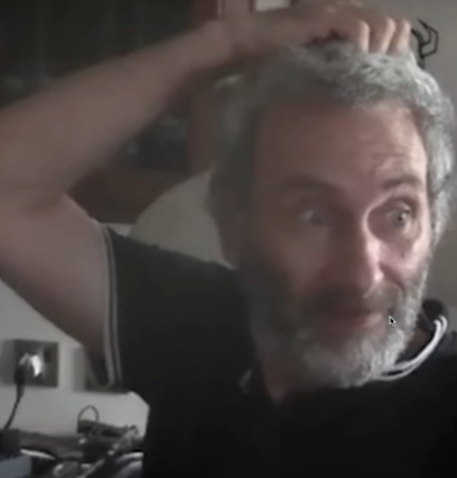

### To jest dramat......
Poniżej kod do wyciąganai nazw pdf z folderu i wprowadzenie do loadera

In [74]:
path="/content/drive/MyDrive/data/fiss"
file_list = []
for (root, dirs, file) in os.walk(path):
    for f in file:
        if '.pdf' in f:
          file_list.append(f)

In [75]:
docs = []

for i in file_list:
    loader = PyPDFLoader(f"/content/drive/MyDrive/data/fiss/{i}")
    pages = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=300,
        chunk_overlap=100,
        length_function=len,
        separators=["\n\n", "\n", " ", ""]
    )
    docs += text_splitter.split_documents(pages)

for idx,doc in enumerate(docs):
  print(f"[{idx}].{doc}\n\n")

[0].page_content='44 Electrical Engineering & Electromechanics, 2025, no. 4 
© I. Kovacova, D. Kovac 
UDC 621.319 https://doi.org/10.20998/2074-272X.2025.4.06 
 
I. Kovacova, D. Kovac 
 
Designing the optimal number of active branches in a multi-branch buck-boost converter' metadata={'producer': 'Acrobat Distiller 11.0 (Windows)', 'creator': 'PScript5.dll Version 5.2.2', 'creationdate': '2025-06-20T14:36:06+03:00', 'author': 'dell', 'moddate': '2025-06-20T14:36:06+03:00', 'title': 'Microsoft Word - 06 Kovacova + PMG.doc', 'source': '/content/drive/MyDrive/data/fiss/Designing_the_optimal_number_of_active_branches_in.pdf', 'total_pages': 9, 'page': 0, 'page_label': '1'}


[1].page_content='Designing the optimal number of active branches in a multi-branch buck-boost converter 
 
Introduction. Multi-branch buck-boost converters, widely used in energy conversion from alternative sources, offer significant advantages' metadata={'producer': 'Acrobat Distiller 11.0 (Windows)', 'creator': 'PScr

Embeding i zapisanie danych do wektorowej bazy danych

In [76]:
model_name = "sentence-transformers/paraphrase-MiniLM-L12-v2"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

db = FAISS.from_documents(docs, embeddings)
db.save_local("faiss_index_hf")

wczytanie z bazy danych i znalezienie fragmentów dokumentu powiązanych z pytaniem

In [77]:
db = FAISS.load_local("faiss_index_hf", embeddings, allow_dangerous_deserialization=True)

query = "What is efficiency of buck boost converter"
similar_docs = db.similarity_search(query, k=3)  # top 3 wyniki

for doc in similar_docs:
    print(doc.page_content[:300] + "...\n---")

parameters in the circuit. This is shown in Effective working 
faster orders, adapting power, and improving the network.  A 
buck-boost converter provides an output voltage that may be 
less than or greater than the input voltage. In this study, a DC-...
---
buck–boost converter is one of the non-isolated converters that can operate in a wide voltage conversion range 
and increase and decrease the input voltage 9. SEPIC, ZETA, and CUK converters are conventional buck–boost...
---
ratio and a lower duty cycle than the conventional buck–boost converter, which leads to increased efficiency. 
However, owing to the elevated gradient of the voltage gain curve, it is difficult to adjust the converter’s voltage...
---


Stosujemy barta ponieważ podobnie do T5 ma zadeklarowany tokenizer w repo (jest łatwiej)

In [78]:
model_name = "facebook/bart-base"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=1024
)

llm = HuggingFacePipeline(pipeline=pipe)

template = """
Answer the question based only on the documents below
IMPORTANT: If you don't find the answer in the documents, write precisely: "I can't find the answer"

Documents:
{context}

Question: {question}
"""

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=template
)

memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True,
    output_key="answer"
)


qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(),
    return_source_documents=True,
    verbose=False
)



Device set to use cpu


Pętla do zadawania do konwersacji z botem

Straszny meksyk tutaj się dzieje nie mam pomysłu co pozmieniać żeby działał normalnie, szukałem wszędzie i zmarnowałem na to ponad 8h

In [ ]:
print("AI Assistant gotowy! Zadaj pytanie (lub wpisz 'exit' aby zakończyć).")

while True:
    query = input("Ty: ")
    if query.lower() in ["exit", "quit", "q"]:
        print("AI Assistant: Do zobaczenia! 👋")
        break

    result = qa_chain.invoke({"query": query})
    answer = result["result"]

    if 'result' in result:
        print(f"\nAI Assistant: {answer}\n")
    else:
        print("\nAI Assistant: Nie potrafie zmaleźć źródła\n")

    if "source_documents" in result:
        print("📚 Źródła:")
        for i, doc in enumerate(result["source_documents"], 1):
            snippet = doc.page_content[:300].replace("\n", " ")
            source_name = doc.metadata.get("source", "Nieznane źródło")
            page = doc.metadata.get("page", "brak numeru strony")
            print(f"--- Źródło {i} ({source_name}, strona {page}) ---\n{snippet}...\n")

AI Assistant gotowy! Zadaj pytanie (lub wpisz 'exit' aby zakończyć).
